# TIMIT performance analysis
This analyzes model performance on the TIMIT corpus, with special attention to performance on vowels

In [1]:
from collections import Counter, defaultdict
from pathlib import Path

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import pandas as pd
import seaborn as sns

sns.color_palette("colorblind")
font = {"size": 16}
matplotlib.rc("font", **font)
# Remove the limits on the number of rows displayed in the notebook
pd.options.display.max_rows = None

In [2]:
GOLD_TRANSCRIPTIONS_CSV = Path("../../data/TIMIT Dataset/complete_ipa.csv")

TIMIT_EVAL_DIR = Path("../../data/timit_results/")
AGG_METRICS_CSV = TIMIT_EVAL_DIR / "aggregate_metrics" / "all_models_eval.csv"
DETAILED_PRED_DIR = TIMIT_EVAL_DIR / "detailed_predictions"
EDIT_DIST_DIR = TIMIT_EVAL_DIR / "edit_distances"

DIALECT_METRICS = Path("../timit_evaluation/Results/timit_dialect_model_comparison.csv")

TIMIT_VOWELS = ["ɑ", "æ", "ʌ", "ɔ", "aʊ", "aɪ", "ɛ", "eɪ", "ɪ", "i", "oʊ", "ɔɪ", "ʊ", "u", "ə", "ə̥", "ʉ", "ɨ"]

DIALECT_REGIONS = {
    "DR1": "DR1: New England",
    "DR2": "DR2: Northern",
    "DR3": "DR3: North Midland",
    "DR4": "DR4: South Midland",
    "DR5": "DR5: Southern",
    "DR6": "DR6: New York City",
    "DR7": "DR7: Western",
    "DR8": "DR8: Army Brat"
}


## Basic model performance comparisons
Show performance metrics for each model on TIMIT. 

In [3]:
# Manually define and join model source description
model_sources = [
    ("allosaurus_eng2102_eng", "Allosaurus English"),
    ("ginic/full_dataset_train_3_wav2vec2-large-xlsr-53-buckeye-ipa", "Our AutoIPA: fine-tuned on full train split"),
    ("ctaguchi/wav2vec2-large-xlsr-japlmthufielta-ipa1000-ns", "Taguchi et al. 2023"),
    ("openai_whisper-large-v3-turbo_to_epitran", "Whisper + Epitran"),
    # Intentionally omitting Whisper medium - let's just keep the best in each category
    # ("openai_whisper-medium.en_to_epitran", "Whisper + Epitran"),
]

model_sources_df = pd.DataFrame(model_sources, columns=["model", "Model source"])


In [4]:
# Read in aggregate performance data
aggregate_perf_df = pd.read_csv(AGG_METRICS_CSV)
aggregate_perf_df = pd.merge(aggregate_perf_df, model_sources_df, on="model").sort_values(by="mean_phone_error_rate")

display(aggregate_perf_df)


,model,mean_phone_error_rate,mean_phone_feature_error_rate,mean_feature_error_rate,substitutions,insertions,deletions,Model source
1,ginic/full_dataset_train_3_wav2vec2-large-xlsr...,0.275325,3.420602,0.216646,43587,6700,7307,Our AutoIPA: fine-tuned on full train split
3,openai_whisper-large-v3-turbo_to_epitran,0.374312,4.463757,0.254656,59592,10681,7731,Whisper + Epitran
0,allosaurus_eng2102_eng,0.391094,4.481382,0.239781,62218,9569,9632,Allosaurus English
2,ctaguchi/wav2vec2-large-xlsr-japlmthufielta-ip...,0.648082,6.092513,0.300393,104664,8546,22864,Taguchi et al. 2023


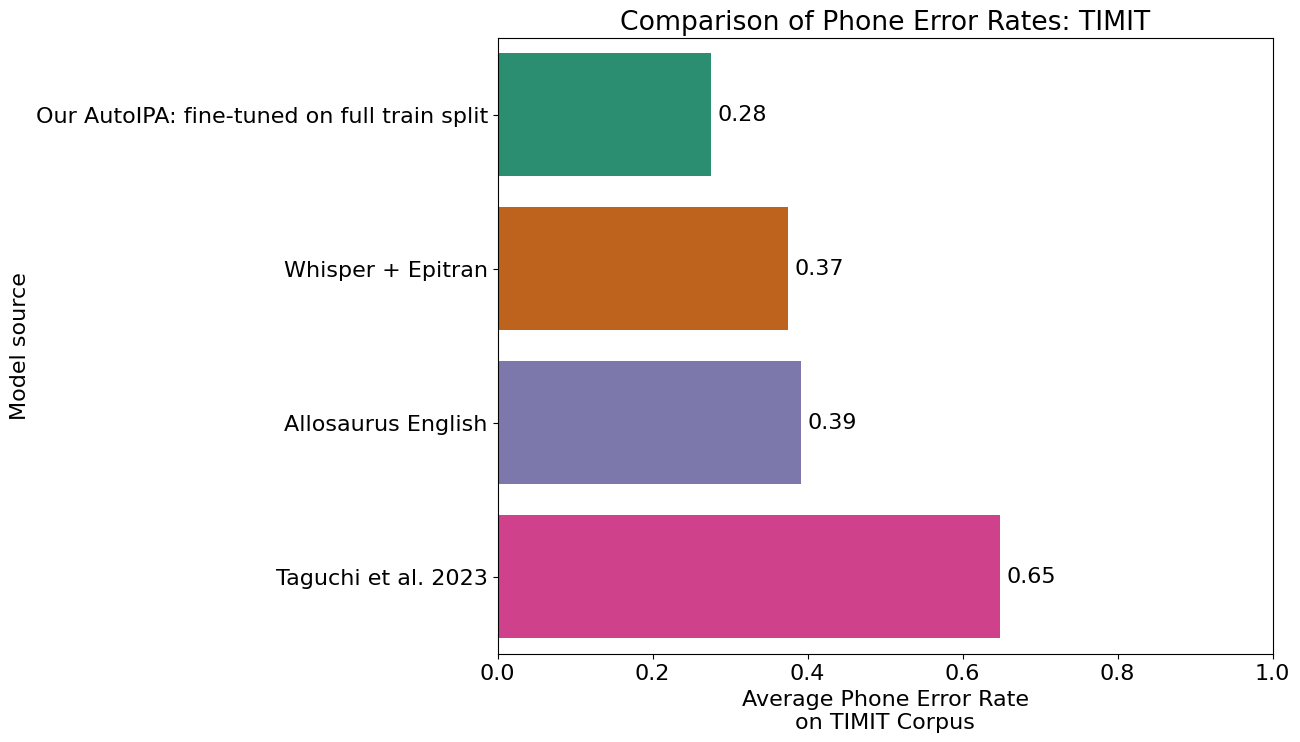

In [5]:
plt.figure(figsize=(10, 8))

g = sns.barplot(
    data=aggregate_perf_df, y="Model source", x="mean_phone_error_rate", hue="Model source", palette="Dark2"
)
g.set_title("Comparison of Phone Error Rates: TIMIT")
g.set_xlabel("Average Phone Error Rate\non TIMIT Corpus")
g.set_xlim((0,1))

for bar in g.containers:
    g.bar_label(bar, fmt="%.2f", padding=5)

In [6]:
# Let's look specifically at substitution errors
substitution_dfs = []
for (model, _) in model_sources:
    file_prefix = model.replace("/", "_")
    edit_dist_path = EDIT_DIST_DIR / f"{file_prefix}_substitutions.csv"
    edit_dist_df = pd.read_csv(edit_dist_path)
    edit_dist_df["model"] = model
    substitution_dfs.append(edit_dist_df)

full_substitution_df = pd.concat(substitution_dfs)
print(full_substitution_df.shape)
display(full_substitution_df.head())

(5910, 4)


,original,substitution,total_substitutions,model
0,ɪ,j,6189,allosaurus_eng2102_eng
1,ɨ,ə,4515,allosaurus_eng2102_eng
2,ɨ,ɪ,3122,allosaurus_eng2102_eng
3,ʊ,w,2980,allosaurus_eng2102_eng
4,ɾ,t,2457,allosaurus_eng2102_eng


Text(0.5, 0, 'Total Substitution Errors\non TIMIT Corpus')

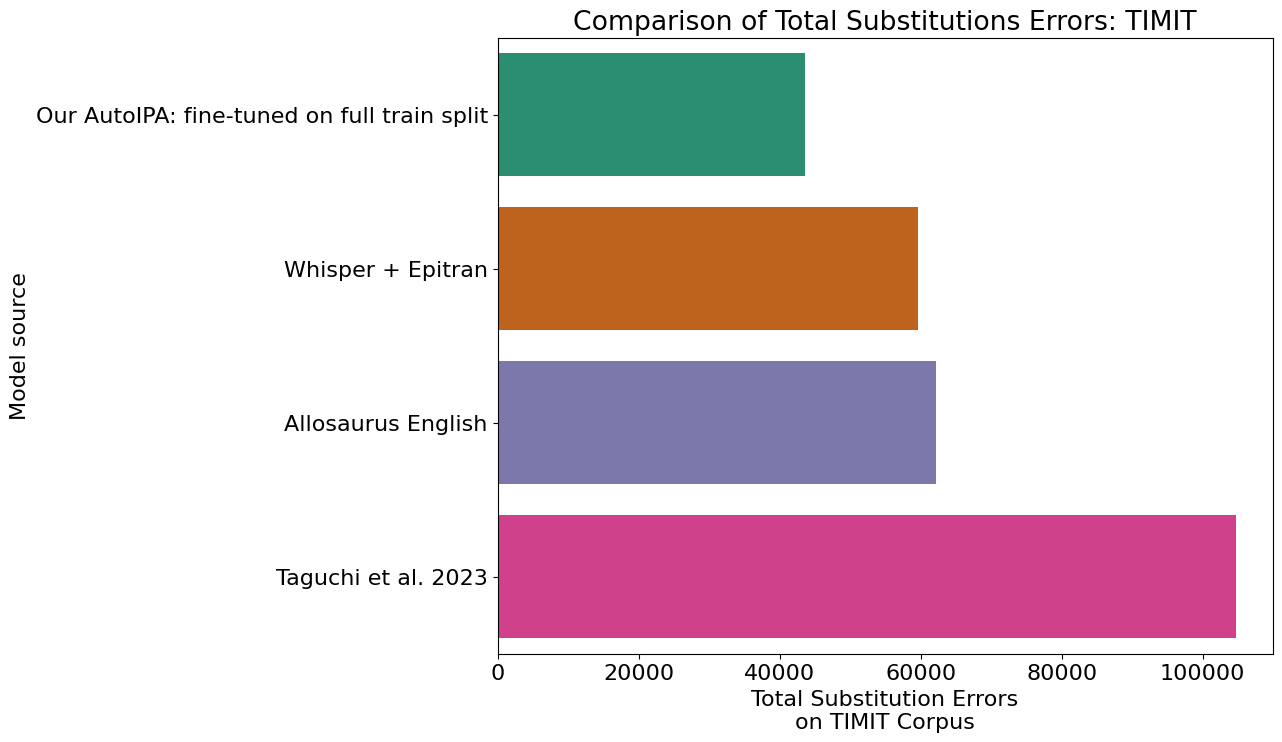

In [7]:
# Calculate total substitution errors for each model
subs_count_df = full_substitution_df.groupby("model")["total_substitutions"].sum().reset_index().sort_values(by="total_substitutions", ascending=True)
subs_count_df = pd.merge(subs_count_df, model_sources_df, on="model")
plt.figure(figsize=(10, 8))

g = sns.barplot(
    data=subs_count_df, y="Model source", x="total_substitutions", hue="Model source", palette="Dark2"
)
g.set_title("Comparison of Total Substitutions Errors: TIMIT")
g.set_xlabel("Total Substitution Errors\non TIMIT Corpus")

# Dialect Region Performance Plots
This creates bar charts showing performance by dialect. Since the groupby and averaging was already done, we just need to read in the data and plot the results.

In [8]:
# Show performance by dialect region
dialect_df = pd.read_csv(DIALECT_METRICS).merge(model_sources_df, on="model")
dialect_df = dialect_df.merge(pd.DataFrame(DIALECT_REGIONS.items(), columns=["dialect", "Dialect Region"]), on="dialect")
dialect_df =  dialect_df.sort_values(by=["Dialect Region", "phone_error_rates"], ascending=[True, True])
display(dialect_df)

,dialect,model,phone_error_rates,phone_feature_error_rates,feature_error_rates,Model source,Dialect Region
1,DR1,ginic/full_dataset_train_3_wav2vec2-large-xlsr...,0.280348,3.354082,0.211852,Our AutoIPA: fine-tuned on full train split,DR1: New England
3,DR1,openai_whisper-large-v3-turbo_to_epitran,0.386002,4.602041,0.256295,Whisper + Epitran,DR1: New England
0,DR1,allosaurus_eng2102_eng,0.401961,4.495918,0.237414,Allosaurus English,DR1: New England
2,DR1,ctaguchi/wav2vec2-large-xlsr-japlmthufielta-ip...,0.645606,6.012245,0.298806,Taguchi et al. 2023,DR1: New England
5,DR2,ginic/full_dataset_train_3_wav2vec2-large-xlsr...,0.262502,3.380719,0.220450,Our AutoIPA: fine-tuned on full train split,DR2: Northern
7,DR2,openai_whisper-large-v3-turbo_to_epitran,0.365522,4.434559,0.256891,Whisper + Epitran,DR2: Northern
4,DR2,allosaurus_eng2102_eng,0.381017,4.410294,0.241293,Allosaurus English,DR2: Northern
6,DR2,ctaguchi/wav2vec2-large-xlsr-japlmthufielta-ip...,0.638122,6.043137,0.299440,Taguchi et al. 2023,DR2: Northern
9,DR3,ginic/full_dataset_train_3_wav2vec2-large-xlsr...,0.264213,3.262051,0.213161,Our AutoIPA: fine-tuned on full train split,DR3: North Midland
11,DR3,openai_whisper-large-v3-turbo_to_epitran,0.370844,4.391095,0.256107,Whisper + Epitran,DR3: North Midland


Text(0.5, 1.05, "Models' Average Phone Error Rates by Dialect Region")

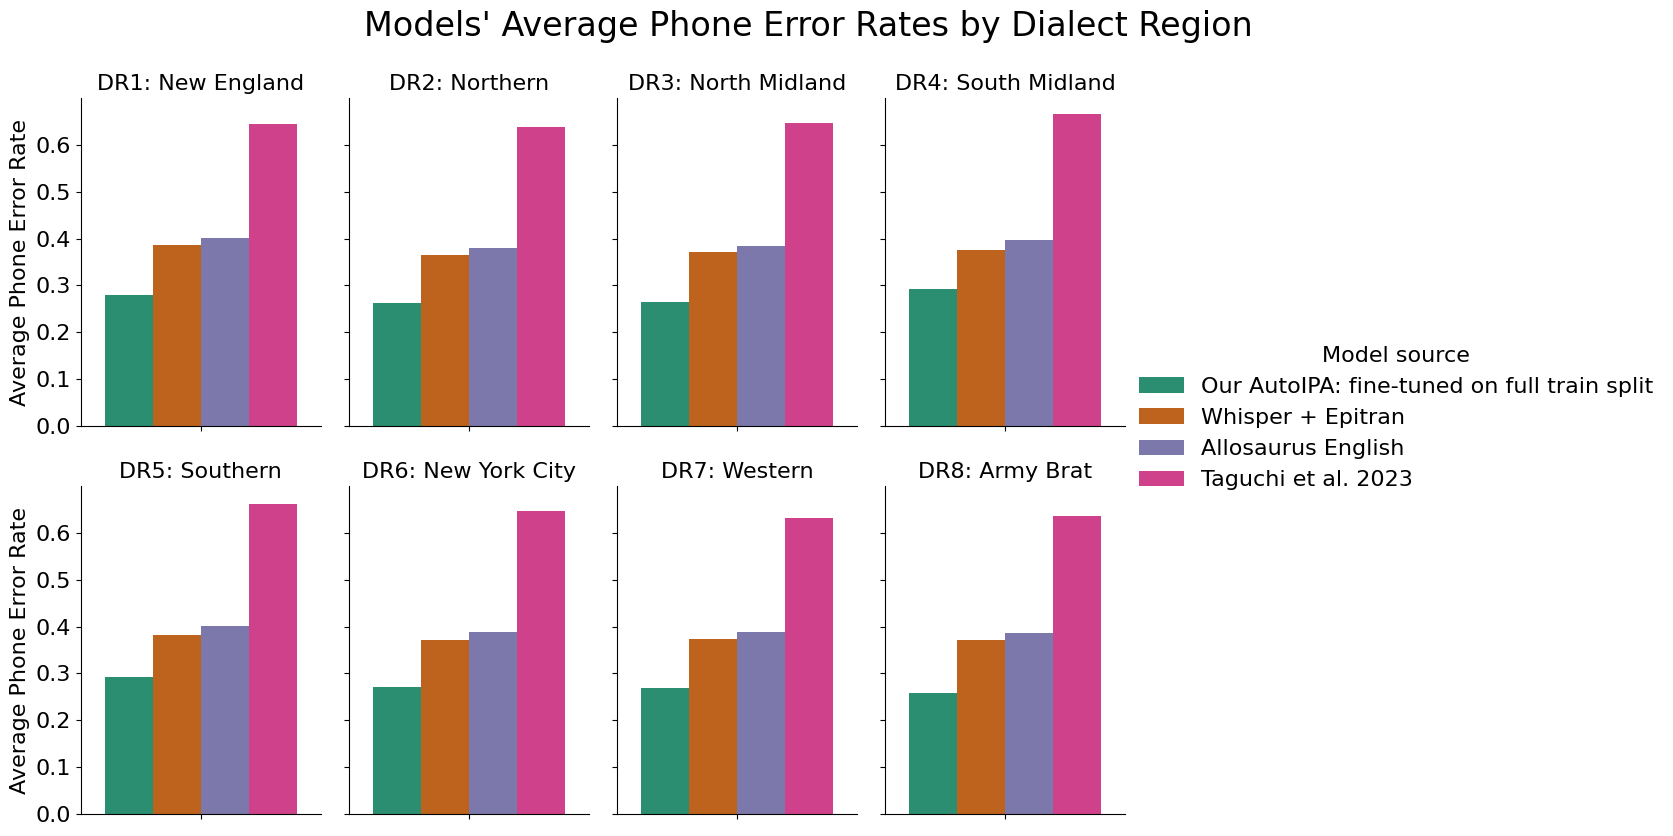

In [9]:
g = sns.FacetGrid(dialect_df, col="Dialect Region", col_wrap=4, height=4, aspect=0.75)
g.set_titles(col_template="{col_name}")
g.map_dataframe(sns.barplot, y="phone_error_rates", hue="Model source", palette="Dark2")
g.add_legend(title="Model source")
g.set_ylabels("Average Phone Error Rate")
g.fig.suptitle("Models' Average Phone Error Rates by Dialect Region", fontsize=24, y=1.05)


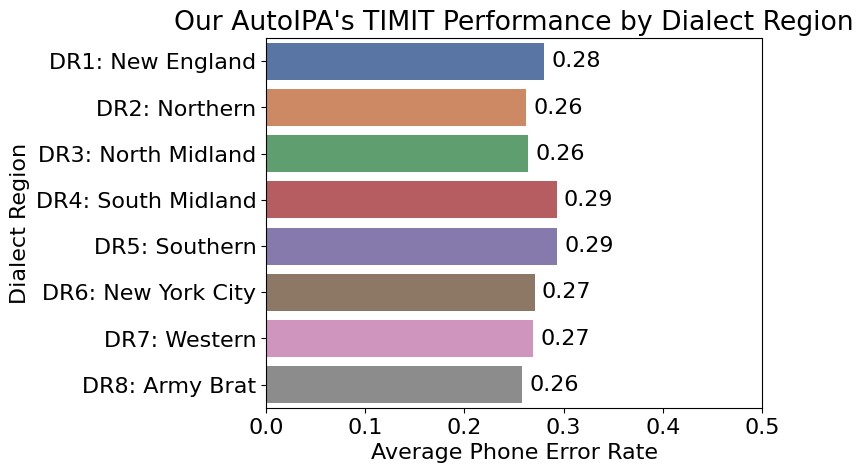

In [10]:
# Dialect performance for just our model
our_model_dialect_df = dialect_df[dialect_df["Model source"] == "Our AutoIPA: fine-tuned on full train split"]
g = sns.barplot(data=our_model_dialect_df, y="Dialect Region", x="phone_error_rates", hue="Dialect Region",palette="deep")
g.set_xlabel("Average Phone Error Rate")
g.set_xlim((0,0.5))
g.set(title="Our AutoIPA's TIMIT Performance by Dialect Region")
for bar in g.containers:
    g.bar_label(bar, fmt="%.2f", padding=5)


# Vowel Error Rate Analysis
How many instances of each vowel in the vocabulary are we getting wrong? 
$$ error\_rate(v) = \frac{count\_substitutions\_of(v) + count\_deletions(v)}{total\_count(v)}$$

In [11]:
gold_transcription_df = pd.read_csv(GOLD_TRANSCRIPTIONS_CSV)
vowel_counts = Counter()
for vowel in TIMIT_VOWELS:
    vowel_counts[vowel] += gold_transcription_df["ipa_transcription"].apply(lambda x: x.split().count(vowel)).sum()

vowel_counts

Counter({'ɨ': 11587,
         'i': 9663,
         'ɪ': 6760,
         'æ': 5404,
         'ɛ': 5293,
         'ə': 4956,
         'ɑ': 4197,
         'ɔ': 4096,
         'aɪ': 3242,
         'ʌ': 3185,
         'eɪ': 3088,
         'oʊ': 2913,
         'ʉ': 2488,
         'ɔɪ': 947,
         'aʊ': 945,
         'ʊ': 756,
         'u': 725,
         'ə̥': 493})

/var/folders/7c/4fzv15450s1bt_03bv1b6hb80000gn/T/ipykernel_18639/4017944078.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  g = sns.barplot(y=plot_vowels, x=plot_counts, palette="deep")


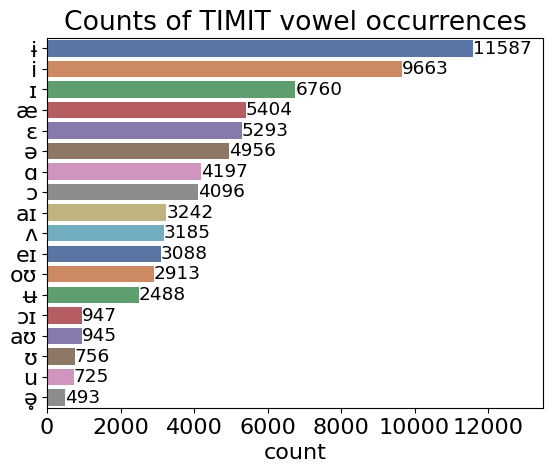

In [12]:
plot_vowels, plot_counts = zip(*vowel_counts.most_common())
g = sns.barplot(y=plot_vowels, x=plot_counts, palette="deep")
g.set_xlim(0, 13500)
g.set_xlabel("count")
g.set(title="Counts of TIMIT vowel occurrences")
for bar in g.containers:
    g.bar_label(bar, fontsize='small')




In [13]:
# Read and tally substitutions and deletions
subs_df = pd.read_csv(EDIT_DIST_DIR / "ginic_full_dataset_train_3_wav2vec2-large-xlsr-53-buckeye-ipa_substitutions.csv")
subs_records = subs_df.to_records(index=False)
detailed_subs_counts = defaultdict(Counter)
subs_counts = Counter()
for (original, sub, count) in subs_records:
    subs_counts[original] += count
    detailed_subs_counts[original][sub] += count

print("Substitution Counts:", subs_counts)

dels_df = pd.read_csv(EDIT_DIST_DIR / "ginic_full_dataset_train_3_wav2vec2-large-xlsr-53-buckeye-ipa_deletions.csv")
dels_records = dels_df.to_records(index=False)
dels_counts = Counter()
for (deleted, count) in dels_records:
    dels_counts[deleted] += count
    detailed_subs_counts[deleted]["<deleted>"] += count

print("Deletion Counts:", dels_counts)
print("Detailed Error Counts:", detailed_subs_counts)

Substitution Counts: Counter({'ɨ': 10878, 'ɚ': 4661, 'ə': 4532, 'g': 2917, 'ʉ': 2464, 'ɪ': 2158, 'ɦ': 1476, 'ʔ': 1335, 't': 1331, 'ɔ': 1087, 'z': 884, 'i': 851, 'ɛ': 617, 'ɹ̩': 610, 'l̩': 584, 'a': 510, 'ɾ̃': 506, 'd': 502, 'n̩': 437, 'ʊ': 384, 'ə̥': 375, 'æ': 374, 'ð': 368, 'n': 363, 'ɑ': 344, 'o': 279, 'ɾ': 278, 'ʌ': 271, 'e': 203, 'ɹ': 200, 'ʒ': 171, 'v': 168, 's': 138, 'ŋ': 136, 'l': 131, 'H': 121, 'm̩': 105, 'p': 102, 'ʃ': 100, 'θ': 97, 'j': 96, 'b': 95, 'm': 76, 'w': 75, 'k': 47, 'u': 45, 'ŋ̍': 43, 'h': 35, 'f': 25, 'ɡ': 2})
Deletion Counts: Counter({'ʔ': 2813, 'ɨ': 709, 'ɪ': 610, 't': 440, 'ə': 424, 'ʊ': 260, 'd': 180, 'n': 165, 'l': 153, 'ɹ': 134, 'ɚ': 129, 'ə̥': 118, 'g': 114, 'h': 92, 'ɔ': 85, 'ɛ': 75, 'ɑ': 67, 'k': 57, 'j': 56, 'ɦ': 47, 'w': 44, 'i': 41, 'æ': 40, 'e': 34, 'v': 33, 'z': 32, 'a': 31, 'p': 29, 'ʉ': 24, 'b': 23, 'm': 22, 's': 21, 'ʌ': 20, 'ɾ̃': 20, 'ʒ': 20, 'ʃ': 18, 'ɾ': 13, 'ð': 13, 'l̩': 13, 'ŋ': 12, 'ɹ̩': 12, 'o': 11, 'f': 10, 'H': 9, 'θ': 9, 'n̩': 9, 'ɡ': 8,

In [14]:
# Compute vowel error rates
vowel_error_rates = {}
for v in TIMIT_VOWELS:
    subs_count = subs_counts[v] if v in subs_counts else 0
    dels_count = dels_counts[v] if v in dels_counts else 0
    ver = (subs_count + dels_count)/ (vowel_counts[v] if v in vowel_counts else 0)
    vowel_error_rates[v] = ver

ver_df = pd.DataFrame(vowel_error_rates.items(), columns=["Vowel", "Vowel Error Rate"]). sort_values(by="Vowel Error Rate", ascending=False)
error_ordering = ver_df[ver_df["Vowel Error Rate"] > 0]["Vowel"].tolist()
print("In descending frequency of errors:", error_ordering)

display(ver_df)


In descending frequency of errors: ['ɨ', 'ʉ', 'ə̥', 'ə', 'ʊ', 'ɪ', 'ɔ', 'ɛ', 'ɑ', 'i', 'ʌ', 'æ', 'u']


,Vowel,Vowel Error Rate
17,ɨ,1.000000
16,ʉ,1.000000
15,ə̥,1.000000
14,ə,1.000000
12,ʊ,0.851852
8,ɪ,0.409467
3,ɔ,0.286133
6,ɛ,0.130739
0,ɑ,0.097927
9,i,0.092311


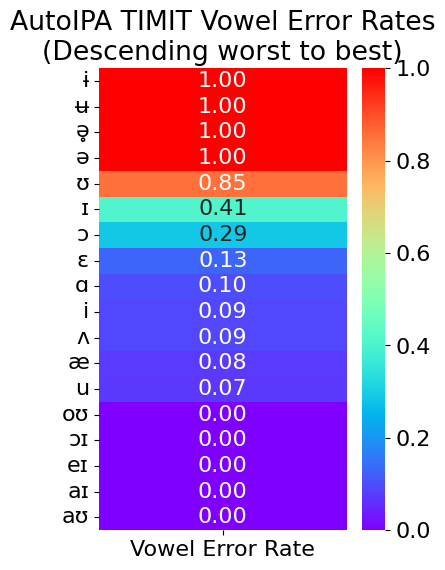

In [20]:
plt.figure(figsize=(4, 6))
sns.heatmap(
    ver_df.sort_values(by="Vowel Error Rate", ascending=False).set_index("Vowel"),
    cmap="rainbow",
    # cmap="spring_r",
    annot=True,
    fmt=".2f",
    # linewidths=1,
)
plt.title("AutoIPA TIMIT Vowel Error Rates\n(Descending worst to best)")
# plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.ylabel("")
plt.show()


In [16]:
interesting_vowels = ver_df[ver_df["Vowel Error Rate"] > 0.0]["Vowel"].tolist()
print(interesting_vowels)


interesting_errors = []
for v in interesting_vowels:
    for error, count in detailed_subs_counts[v].items():
        interesting_errors.append((v, error, count))

interesting_errors_df = pd.DataFrame(interesting_errors, columns=["Vowel", "Error", "Count"])
interesting_errors_df["Ratio of Vowel's Errors"] = interesting_errors_df.groupby("Vowel", group_keys=False)["Count"].apply(lambda x: x / x.sum())
display(interesting_errors_df.head())


['ɨ', 'ʉ', 'ə̥', 'ə', 'ʊ', 'ɪ', 'ɔ', 'ɛ', 'ɑ', 'i', 'ʌ', 'æ', 'u']


,Vowel,Error,Count,Ratio of Vowel's Errors
0,ɨ,ɪ,4704,0.405972
1,ɨ,ʌ,2634,0.227324
2,ɨ,ɛ,1777,0.153362
3,ɨ,i,780,0.067317
4,ɨ,ʊ,207,0.017865


In [17]:
# Grab top ten errors for each vowel
top_errors_df = interesting_errors_df.groupby("Vowel").apply(lambda x: x.nlargest(5, "Count")).reset_index(drop=True)
top_errors_df["Vowel"] = pd.Categorical(top_errors_df["Vowel"], categories=error_ordering, ordered=True)
top_errors_df = top_errors_df.sort_values(by=["Vowel", "Count"], ascending=[True, False])
display(top_errors_df.head(20))

,Vowel,Error,Count,Ratio of Vowel's Errors
40,ɨ,ɪ,4704,0.405972
41,ɨ,ʌ,2634,0.227324
42,ɨ,ɛ,1777,0.153362
43,ɨ,i,780,0.067317
44,ɨ,<deleted>,709,0.061189
50,ʉ,u,2081,0.836415
51,ʉ,ɪ,96,0.038585
52,ʉ,j,91,0.036576
53,ʉ,ʊ,38,0.015273
54,ʉ,t,31,0.012460


/var/folders/7c/4fzv15450s1bt_03bv1b6hb80000gn/T/ipykernel_18639/1493157025.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  convention_errors_df["Vowel"] = pd.Categorical(convention_errors_df["Vowel"], categories=convention_errors, ordered=True)


Text(0.5, 1.05, 'Top 5 errors for vowels AutoIPA always incorrectly transcribes')

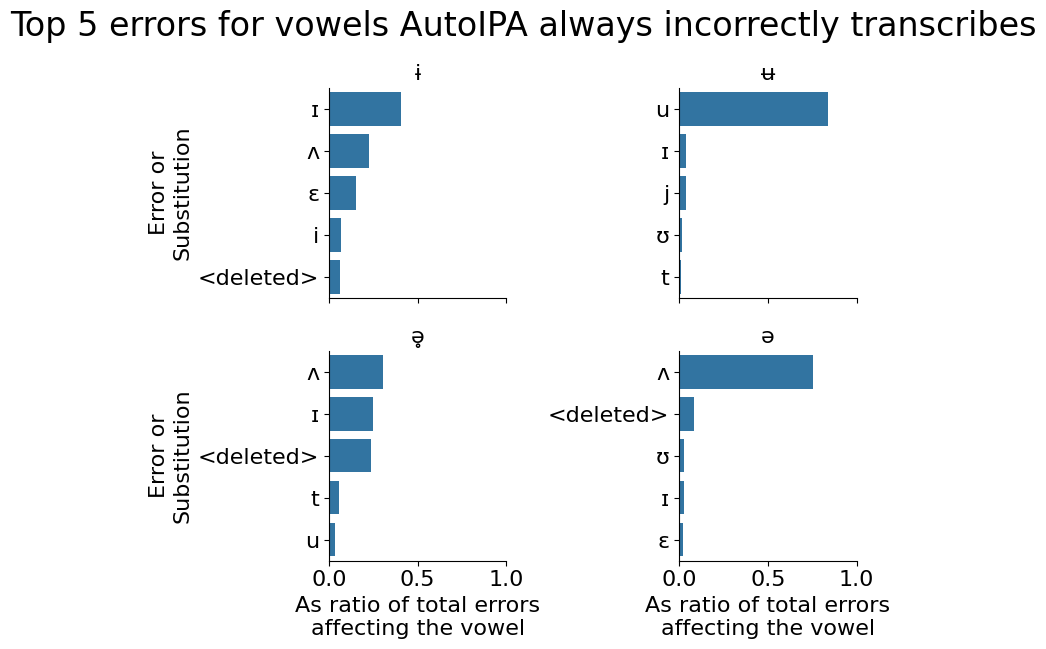

In [18]:
convention_errors=["ɨ", "ʉ", "ə̥", "ə"]

convention_errors_df = top_errors_df[top_errors_df["Vowel"].isin(convention_errors)]
convention_errors_df["Vowel"] = pd.Categorical(convention_errors_df["Vowel"], categories=convention_errors, ordered=True)
g = sns.FacetGrid(convention_errors_df, col="Vowel", col_wrap=2, sharey=False, xlim=(0, 1), aspect=1.25)
g.map_dataframe(sns.barplot, x="Ratio of Vowel's Errors", y="Error", orient="h")
g.set_titles(col_template="{col_name}")
g.set_ylabels("Error or\nSubstitution")
g.set_xlabels("As ratio of total errors\naffecting the vowel")
g.fig.suptitle("Top 5 errors for vowels AutoIPA always incorrectly transcribes", fontsize=24, y=1.05)


['ʊ', 'ɪ', 'ɔ', 'ɛ', 'ɑ', 'i', 'ʌ', 'æ', 'u']


/var/folders/7c/4fzv15450s1bt_03bv1b6hb80000gn/T/ipykernel_18639/3716590903.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  not_convention_errors_df["Vowel"] = pd.Categorical(


,Vowel,Error,Count,Ratio of Vowel's Errors
55,ʊ,<deleted>,260,0.403727
56,ʊ,ʌ,154,0.239130
57,ʊ,l,61,0.094720
58,ʊ,ɪ,27,0.041925
59,ʊ,u,25,0.038820
45,ɪ,ɛ,942,0.340318
46,ɪ,<deleted>,610,0.220376
47,ɪ,i,403,0.145592
48,ɪ,ʌ,364,0.131503
49,ɪ,ʊ,96,0.034682


Text(0.5, 1.05, 'Remaining TIMIT Vowels: Top 5 AutoIPA Errors for each vowel')

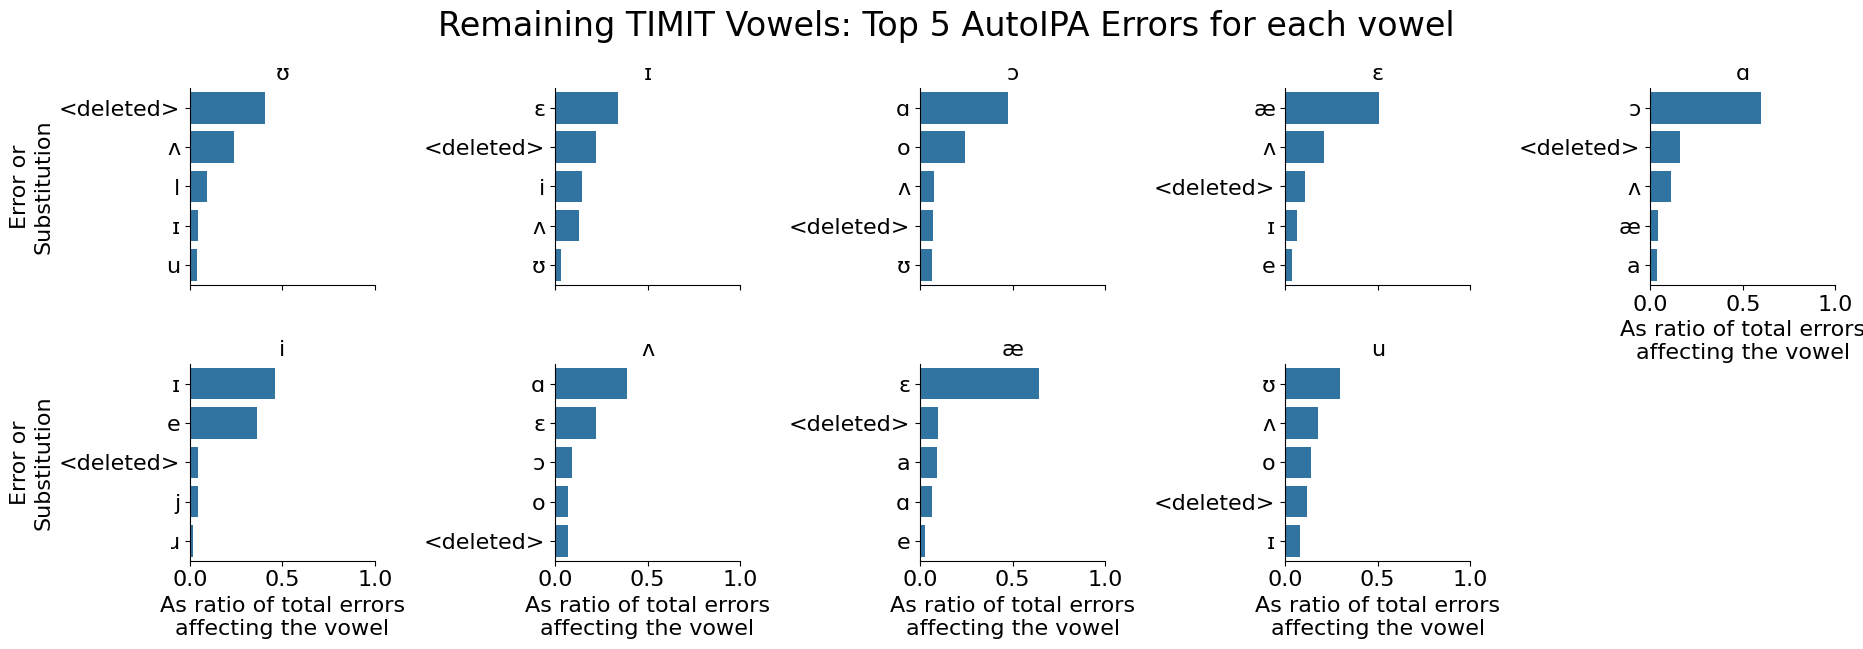

In [19]:
not_convention_errors = [v for v in interesting_vowels if v not in convention_errors]
print(not_convention_errors)
not_convention_errors_df = top_errors_df[top_errors_df["Vowel"].isin(not_convention_errors)]
not_convention_errors_df["Vowel"] = pd.Categorical(
not_convention_errors_df["Vowel"], categories=not_convention_errors, ordered=True
)
display(not_convention_errors_df.head(20))

g = sns.FacetGrid(not_convention_errors_df, col="Vowel", col_wrap=5, sharey=False, aspect=1.25, xlim=(0, 1))
g.map_dataframe(sns.barplot, x="Ratio of Vowel's Errors", y="Error", orient="h")
g.set_titles(col_template="{col_name}", fontsize=20)
g.set_ylabels("Error or\nSubstitution")
g.set_xlabels("As ratio of total errors\naffecting the vowel")
g.fig.suptitle("Remaining TIMIT Vowels: Top 5 AutoIPA Errors for each vowel", fontsize=24, y=1.05)